In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
from scipy.interpolate import interp1d

from sklearn.impute import KNNImputer
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
warnings.filterwarnings('ignore')

import glob
from tqdm.notebook import tqdm


import scienceplots
plt.style.use(['ieee','bright','no-latex'])
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["figure.titleweight"]=25

np.random.seed(2)

In [2]:
def linear_int(data):
    valid_indices = np.arange(len(data))
    valid_data = ~np.isnan(data)
    interpolated_data = np.interp(valid_indices, valid_indices[valid_data], data[valid_data])
    return list(interpolated_data)

def knn_interpolate(data):
    arr=data.copy()
    time=np.arange(1,len(arr)+1,1)
    df=pd.DataFrame({'time':time,'arr':arr})
    knn=KNNImputer(n_neighbors=10)
    imputed=pd.DataFrame(knn.fit_transform(np.array(df)),columns=df.columns)['arr'].values
    return imputed


def spline_interpolation(arr, degree):
    x=arr.copy()
    nan_indices = np.isnan(x)
    non_nan_indices = np.arange(len(x))[~nan_indices]
    non_nan_values = arr[~nan_indices]

    if degree==1:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='slinear', fill_value='extrapolate')
    elif degree==2:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='quadratic', fill_value='extrapolate')
    elif degree==3:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='cubic', fill_value='extrapolate')
    
    interpolated_values = interpolator(np.arange(len(x)))

    return interpolated_values

In [3]:
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

def hierarchical_clustering_dtw(time_series_data, num_clusters):
    # Compute the distance matrix using DTW
    n = len(time_series_data)
    distance_matrix = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            distance_matrix[i][j] = dtw(time_series_data[i], time_series_data[j])
    
    # Perform hierarchical clustering using average linkage
    linkage_matrix = linkage(distance_matrix, method='ward') # average worked
    
    # Plot dendrogram
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Time Series Index')
    plt.ylabel('Distance')
    plt.show()
    
    # Extract cluster labels from dendrogram
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    return cluster_labels

In [4]:
def process_files(dataframe):
    dataframe['from date']=pd.to_datetime(dataframe['from date'])
    sid=dataframe['siteId'].unique()[0]
    #dataframe=dataframe[(dataframe['from date']>='01-01-2023')&(dataframe['from date']<='31-12-2023')]
    dataframe = dataframe[['from date','PM2.5','PM10','SO2',"NO2",'Ozone','NH3']]
    cols = ['PM2.5','PM10','SO2',"NO2",'Ozone','NH3']
    arr=[]

    dataframe = dataframe.resample('D', on='from date').mean().reset_index()

    cols=['PM2.5','PM10','SO2','NO2','Ozone','NH3']

    for col in cols:
        try:
            dataframe[col]=linear_int(dataframe[col])
        except:
            return False,arr  ## Modified process_file here
    
    
    for col in cols:
        arr.append(np.array(dataframe[col].values))

    return True,np.array(arr).T

In [5]:
path_data="D:\\BTP\\Data\\site_data_processed"
csv_files=glob.glob(path_data+'/*.csv')
cols=['PM2.5','PM10','SO2','NO2','Ozone','NH3']

df_site=pd.read_csv('site_info.csv')

df_comp_dup=pd.read_excel('Score_all_files.xlsx')
df_mad_anoms=pd.read_excel('MAD_anomalies.xlsx')

cols_names=list(df_mad_anoms.columns)
cols_names[0]='SiteId'
df_mad_anoms.columns=cols_names

#req_ids=df_site[df_site['City']=='Delhi'].reset_index(drop=True).siteId.values
#filtered_df=df_comp_dup[df_comp_dup['SiteId'].isin(req_ids)]
filtered_df=df_comp_dup.merge(df_mad_anoms,on='SiteId')
filtered_df

SiteId                               SiteName  PM2.5_score  \
0     site_103         CRRI Mathura Road, Delhi - IMD       0.9504   
1     site_104           Burari Crossing, Delhi - IMD       0.3030   
2     site_105          North Campus, DU, Delhi - IMD       0.8810   
3     site_106          IGI Airport (T3), Delhi - IMD       0.8190   
4     site_107                      Pusa, Delhi - IMD       0.8203   
..         ...                                    ...          ...   
508  site_5848          HB Colony, Vijayawada - APPCB       0.0000   
509  site_5849  Rajiv Gandhi Park, Vijayawada - APPCB       0.0000   
510  site_5850            Bhoiwada, Dungarpur - RSPCB       0.0000   
511  site_5851            Mudtra Sili, Jalore - RSPCB       0.0000   
512  site_5852            New Moti Bagh, Delhi - MHUA       0.0000   

     PM10_score  SO2_score  NO2_score  Ozone_score  NH3_score  \
0        0.8954        0.0     0.9440       0.9550        0.0   
1        0.3206        0.0     0.2155       0.2805        0.0   
2        0.8786        0.0     0.8863       0.8965        0.0   
3        0.8289        0.0     0.7762       0.8359        0.0   
4        0.8504        0.0     0.8628       0.8323        0.0   
..          ...        ...        ...          ...        ...   
508      0.0000        0.0     0.0000       0.0000        0.0   
509      0.0000        0.0     0.0000       0.0000        0.0   
510      0.0000        0.0     0.0000       0.0000        0.0   
511      0.0000        0.0     0.0000       0.0000        0.0   
512      0.0000        0.0     0.0000       0.0000        0.0   

     PM2.5_dup_score  PM10_dup_score  ...  NO2_dup_score  Ozone_dup_score  \
0           0.046234        0.008562  ...       3.165009         0.012557   
1           0.007991        0.065640  ...       0.098746         0.277402   
2           0.009133        0.049088  ...       0.182652         0.861887   
3           0.010274        0.074773  ...       0.808233         0.006279   
4           0.014840        0.013699  ...       0.013699         0.057079   
..               ...             ...  ...            ...              ...   
508         0.139843        0.138130  ...       0.000000         0.000000   
509         0.164386        0.163816  ...       0.000000         0.000000   
510         0.180368        0.180939  ...       0.002283         0.000000   
511         0.143838        0.115299  ...       0.000000         0.000000   
512         0.121577        0.000000  ...       0.000000         0.000000   

     NH3_dup_score                           station_name PM2.5_anom_perc  \
0         0.000000         CRRI Mathura Road, Delhi - IMD        0.011164   
1         0.000000           Burari Crossing, Delhi - IMD        0.010023   
2         0.000000          North Campus, DU, Delhi - IMD        0.011164   
3         0.000000          IGI Airport (T3), Delhi - IMD        0.009498   
4         0.000000                      Pusa, Delhi - IMD        0.010023   
..             ...                                    ...             ...   
508       0.000000          HB Colony, Vijayawada - APPCB        0.000023   
509       0.000000  Rajiv Gandhi Park, Vijayawada - APPCB        0.000068   
510       0.053083            Bhoiwada, Dungarpur - RSPCB        0.000000   
511       0.002854            Mudtra Sili, Jalore - RSPCB        0.000000   
512       0.000000            New Moti Bagh, Delhi - MHUA        0.000000   

     PM10_anom_perc  SO2_anom_perc  NO2_anom_perc  Ozone_anom_perc  \
0          0.015799       0.000000       0.003470         0.015959   
1          0.013402       0.000000       0.002192         0.013721   
2          0.016689       0.000000       0.005228         0.019886   
3          0.017374       0.000000       0.003699         0.006484   
4          0.014087       0.000000       0.009909         0.009087   
..              ...            ...            ...              ...   
508        0.000046       0.000000       0.000

### RULE 1 : Remove if any columnn is completely absent in dataframe

In [32]:
filtered_df=filtered_df[(filtered_df['PM2.5_score']>0.01)&(filtered_df['PM10_score']>0.01)&(filtered_df['SO2_score']>0.01)&
            (filtered_df['NO2_score']>0.01)&(filtered_df['Ozone_score']>0.01)&(filtered_df['NH3_score']>0.01)].reset_index(drop=True)
len(filtered_df)

102

In [ ]:
# filtered_df[['PM2.5_anom_perc', 'PM10_anom_perc','SO2_anom_perc', 'NO2_anom_perc', 'Ozone_anom_perc', 'NH3_anom_perc']].plot(kind='box', 
#                                                                                               figsize=(12, 4), 
#                                                                                               vert=True, 
#                                                                                               patch_artist=True,  # Fill box with colors
#                                                                                               notch=True,  # Add notches
#                                                                                               meanline=True,  # Show mean line
#                                                                                               showmeans=True,  # Show mean
#                                                                                               boxprops=dict(facecolor='lightblue', color='black'),  # Box color
#                                                                                               medianprops=dict(color='red'),  # Median line color
#                                                                                               whiskerprops=dict(color='black'),  # Whisker color
#                                                                                               capprops=dict(color='black'))  # Cap color

# # Set title and labels
# plt.title('Box Plot for % Anomalies across all stations')
# plt.xlabel('Pollutants')
# plt.ylabel('Score')

# # Customize x-axis ticks
# plt.xticks(ticks=range(1, 7), labels=['PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone', 'NH3'])

# # Add grid for better readability
# plt.grid(True, linestyle='--', alpha=0.7)


In [ ]:
# filtered_df[['PM2.5_score','PM10_score','SO2_score','NO2_score','Ozone_score','NH3_score']].plot(kind='box', 
#                                                                                               figsize=(12, 4), 
#                                                                                               vert=True, 
#                                                                                               patch_artist=True,  # Fill box with colors
#                                                                                               notch=True,  # Add notches
#                                                                                               meanline=True,  # Show mean line
#                                                                                               showmeans=True,  # Show mean
#                                                                                               boxprops=dict(facecolor='lightblue', color='black'),  # Box color
#                                                                                               medianprops=dict(color='red'),  # Median line color
#                                                                                               whiskerprops=dict(color='black'),  # Whisker color
#                                                                                               capprops=dict(color='black'))  # Cap color

# # Set title and labels
# plt.title('Box Plot for Completeness Score')
# plt.xlabel('Pollutants')
# plt.ylabel('Score')

# # Customize x-axis ticks
# plt.xticks(ticks=range(1, 7), labels=['PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone', 'NH3'])

# # Add grid for better readability
# plt.grid(True, linestyle='--', alpha=0.7)

# # Show the plot
# plt.show()

In [6]:
filtered_df['Anomalies_Score']=(1-filtered_df.iloc[:, -6:].prod(axis=1))
filtered_df['Completeness_Score']=(filtered_df.iloc[:, 2:8].prod(axis=1))
filtered_df['Overall_Score']=filtered_df[['Anomalies_Score','Completeness_Score']].prod(axis=1)
filtered_df[['SiteId','SiteName','Anomalies_Score','Completeness_Score','Overall_Score']].sort_values(by='Overall_Score')

SiteId                                          SiteName  \
0     site_103                    CRRI Mathura Road, Delhi - IMD   
209  site_5269                   Deen Dayal Nagar, Sagar - MPPCB   
190  site_5128                      Gomti Nagar, Lucknow - UPPCB   
157  site_5068                    Sahilara, Maihar - KJS Cements   
137  site_5042                 Shasthri Nagar, Ratlam - IPCA Lab   
..         ...                                               ...   
42   site_1421      Dr. Karni Singh Shooting Range, Delhi - DPCC   
79   site_1562                  Sri Aurobindo Marg, Delhi - DPCC   
38   site_1416                        Padmapukur, Howrah - WBPCB   
61   site_1450                        Kalal Majra, Khanna - PPCB   
46   site_1425  Major Dhyan Chand National Stadium, Delhi - DPCC   

     Anomalies_Score  Completeness_Score  Overall_Score  
0                1.0            0.000000       0.000000  
209              1.0            0.000000       0.000000  
190              1.0            0.000000       0.000000  
157              1.0            0.000000       0.000000  
137              1.0            0.000000       0.000000  
..               ...                 ...            ...  
42               1.0            0.656089       0.656089  
79               1.0            0.661590       0.661590  
38               1.0            0.668942       0.668942  
61               1.0            0.673768       0.673768  
46               1.0            0.681088       0.681088  

[513 rows x 5 columns]

In [21]:
filtered_df=filtered_df[filtered_df['Overall_Score']>0.1006]
len(filtered_df)

102

In [22]:
site_ids=filtered_df['SiteId'].values
timeseries_data=[]
site_id_df=[]
for file_name in tqdm(csv_files):
    df=pd.read_csv(file_name)
    if df['siteId'].unique()[0] in site_ids:
        temp,arr=process_files(df)
        if temp:
            timeseries_data.append(arr)
            site_id_df.append(str(df['siteId'].unique()[0]))
            
timeseries_data=np.array(timeseries_data)
timeseries_data.shape

  0%|          | 0/513 [00:00<?, ?it/s]

(102, 1826, 6)

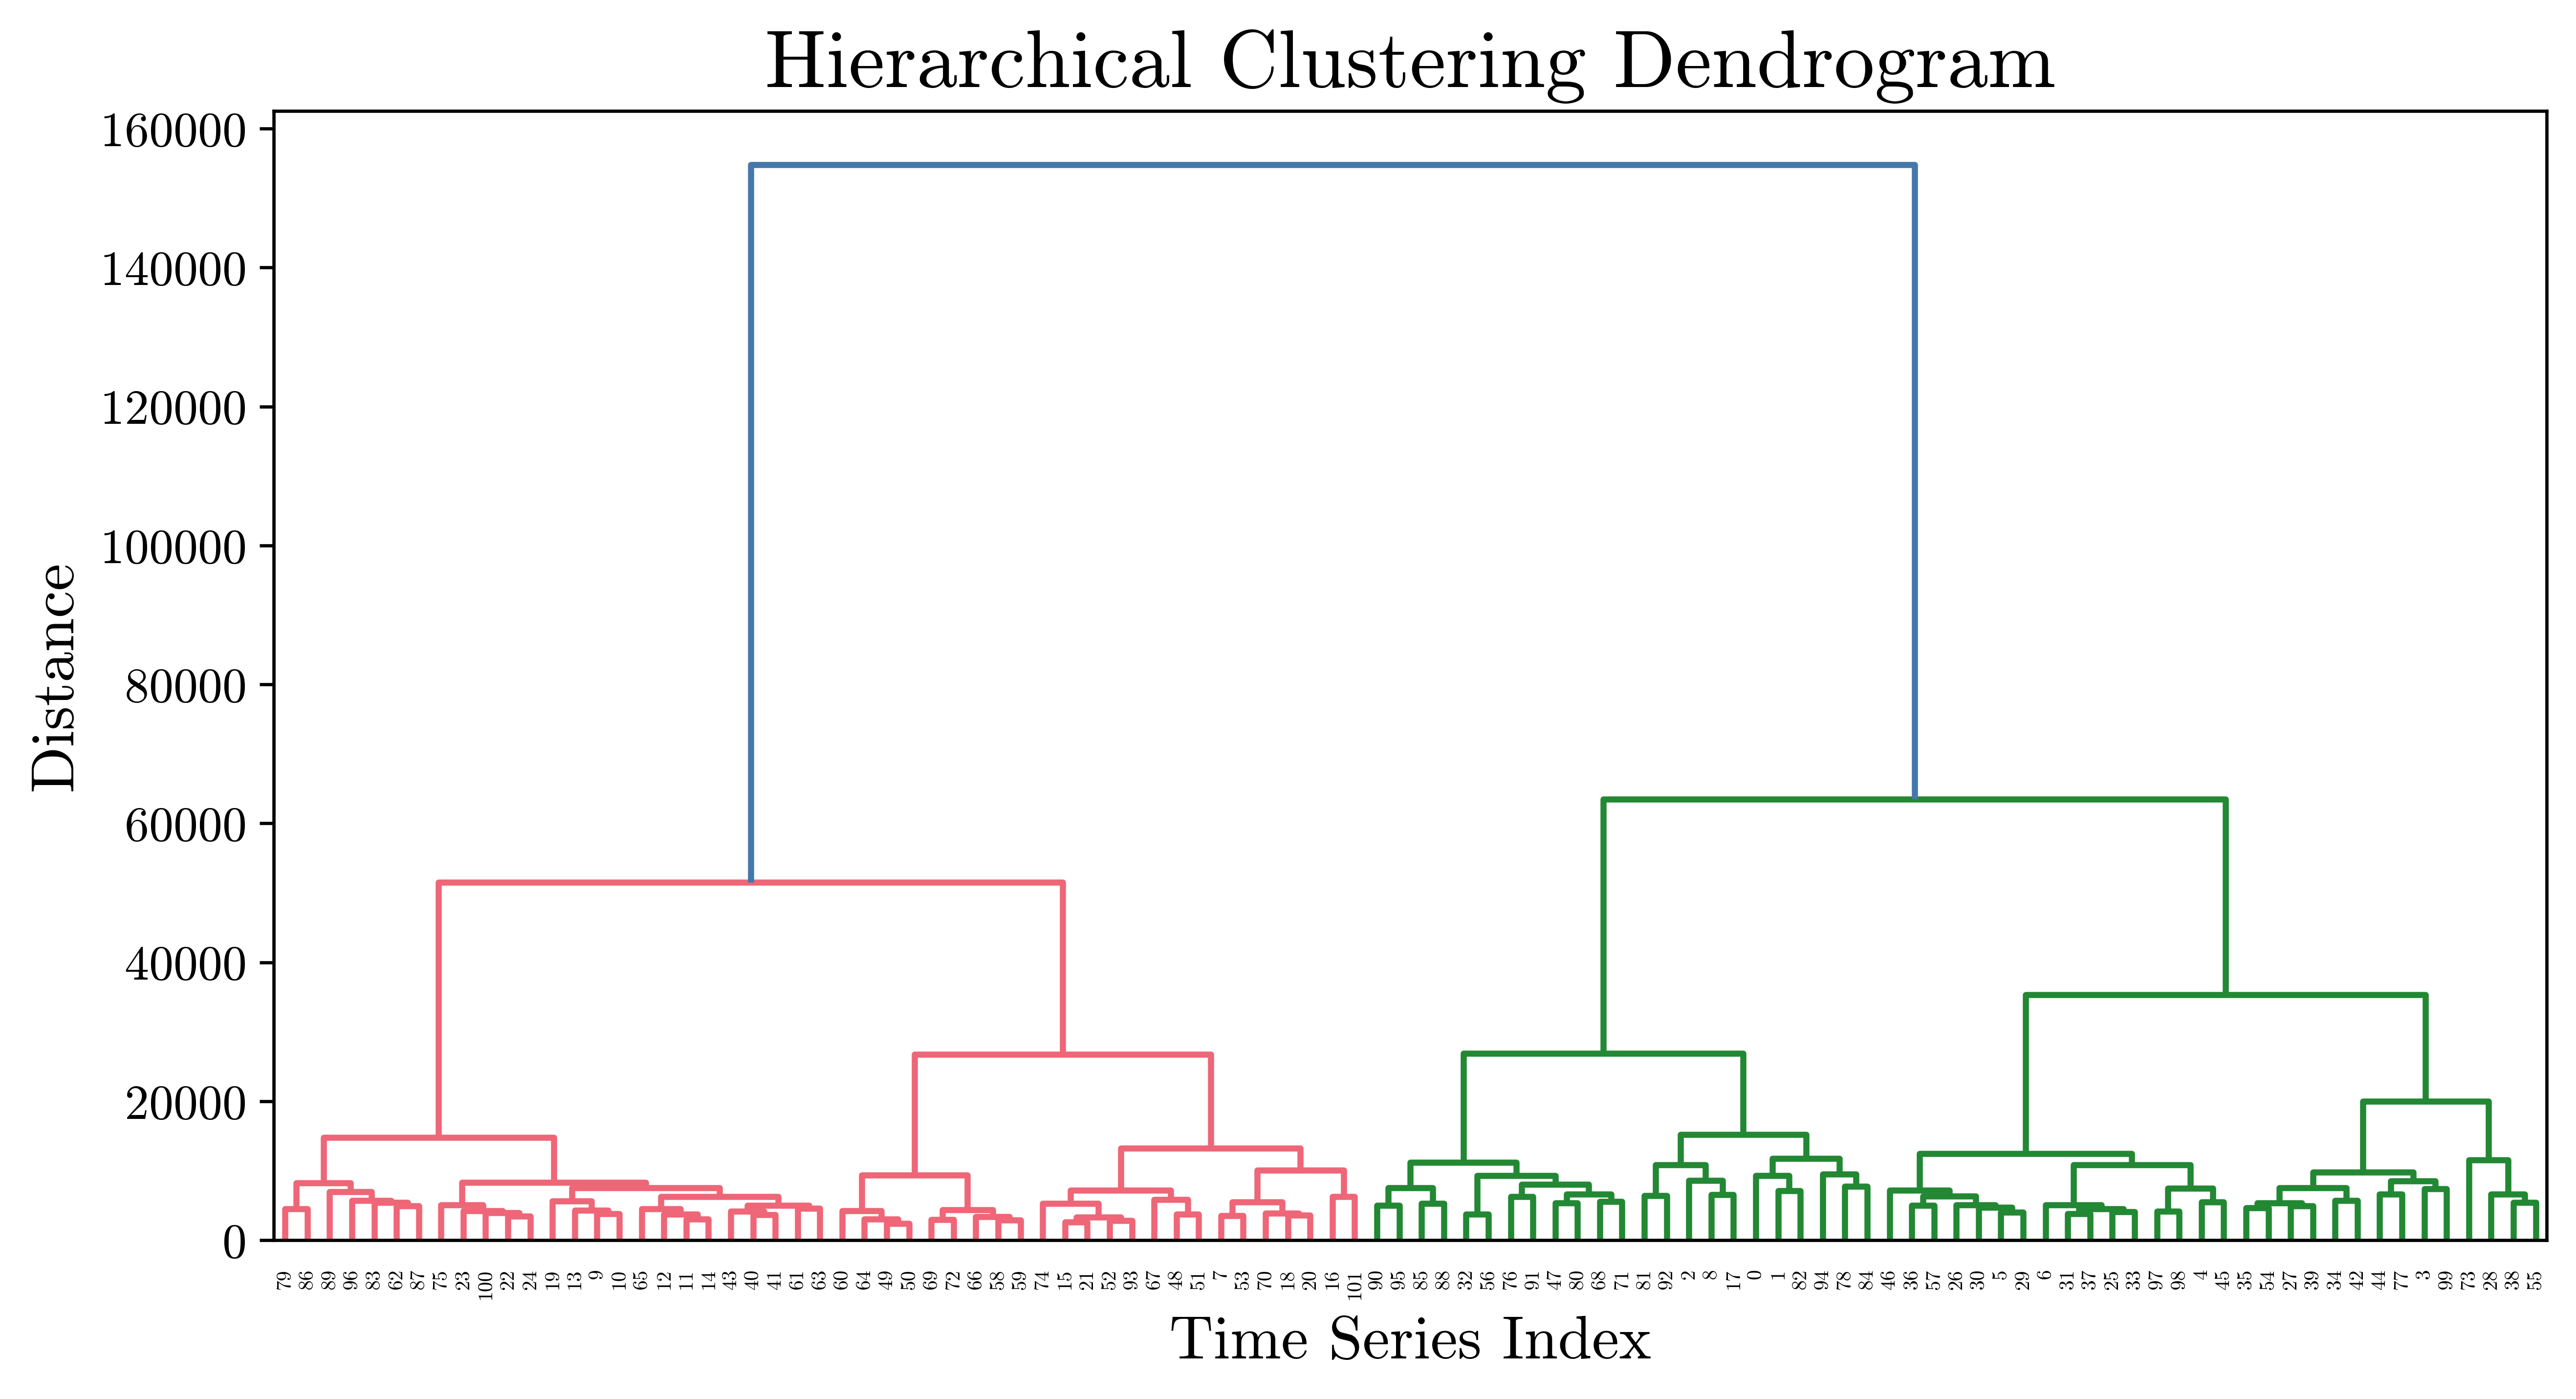

In [27]:
num_clusters = 3
cluster_labels = hierarchical_clustering_dtw(timeseries_data, num_clusters)

In [28]:
df_site_clustered=pd.DataFrame({"siteId":site_id_df})
df_site=pd.read_csv('site_info.csv')
df_site_clustered['cluster']=cluster_labels
#df_site_clustered=df_site.merge(df_site_clustered,on='siteId')
df_site_clustered.cluster.value_counts()

cluster
1    49
3    30
2    23
Name: count, dtype: int64

In [ ]:
#df_site_clustered=pd.read_csv('358_stations_hclustered.csv')

In [53]:
df_site_clustered

siteId  cluster
0     site_113        2
1     site_115        2
2     site_117        2
3     site_118        3
4     site_119        3
..         ...      ...
97   site_5081        3
98   site_5082        3
99   site_5083        3
100  site_5101        1
101  site_5111        1

[102 rows x 2 columns]

In [30]:
def timeseries_plot(data,n_clusters,labels):

    cols = ['PM2.5','PM10','SO2',"NO2",'Ozone','NH3']
    

    for col_num in range(len(cols)):
        dic={i+1:[] for i in range(n_clusters)}
        for label_num in range(len(labels)):
            dic[labels[label_num]].append(data[label_num].T[col_num])

        #plt.figure(figsize=(15,8))
        #plt.title(cols[col_num])
        
        for k in range(num_clusters):
            plt.subplot(2,3,k+1)   
            for p in range(len(dic[k+1])):
                plt.plot(dic[k+1][p])
        plt.suptitle(cols[col_num],fontsize=15)
        plt.tight_layout(pad=1)
        plt.show()
    return        

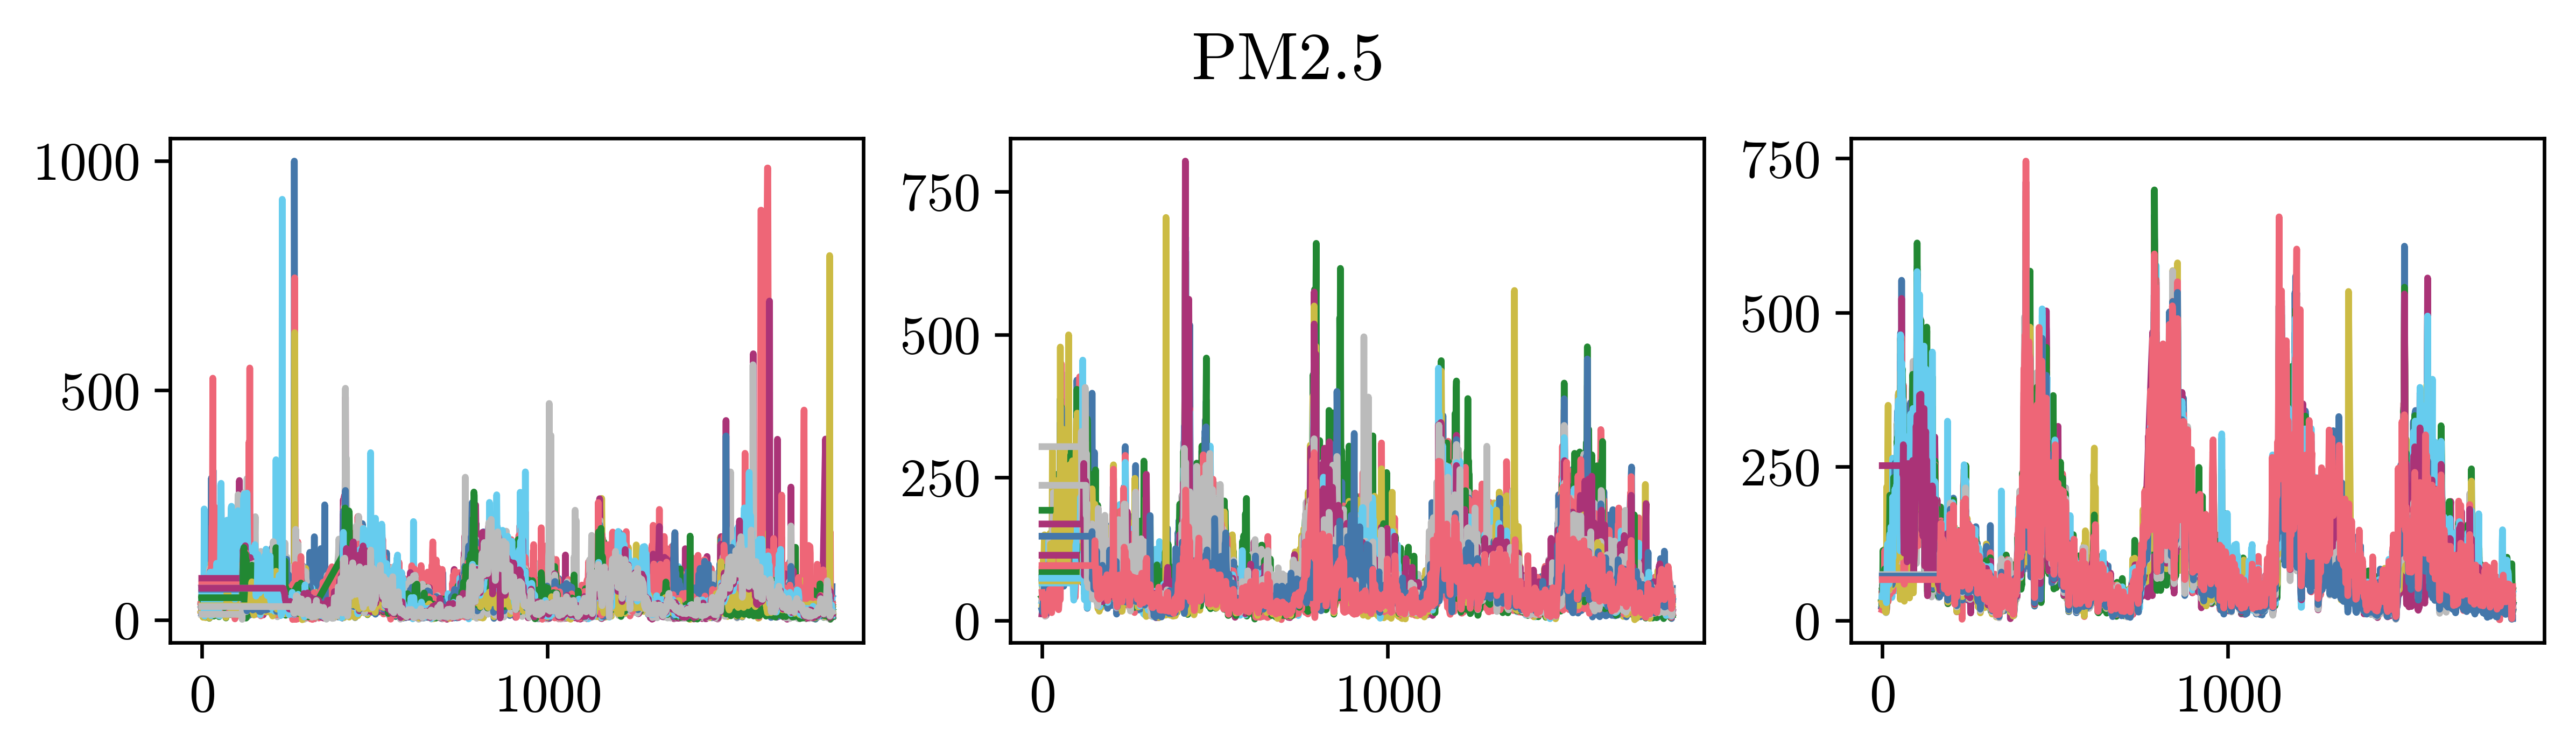

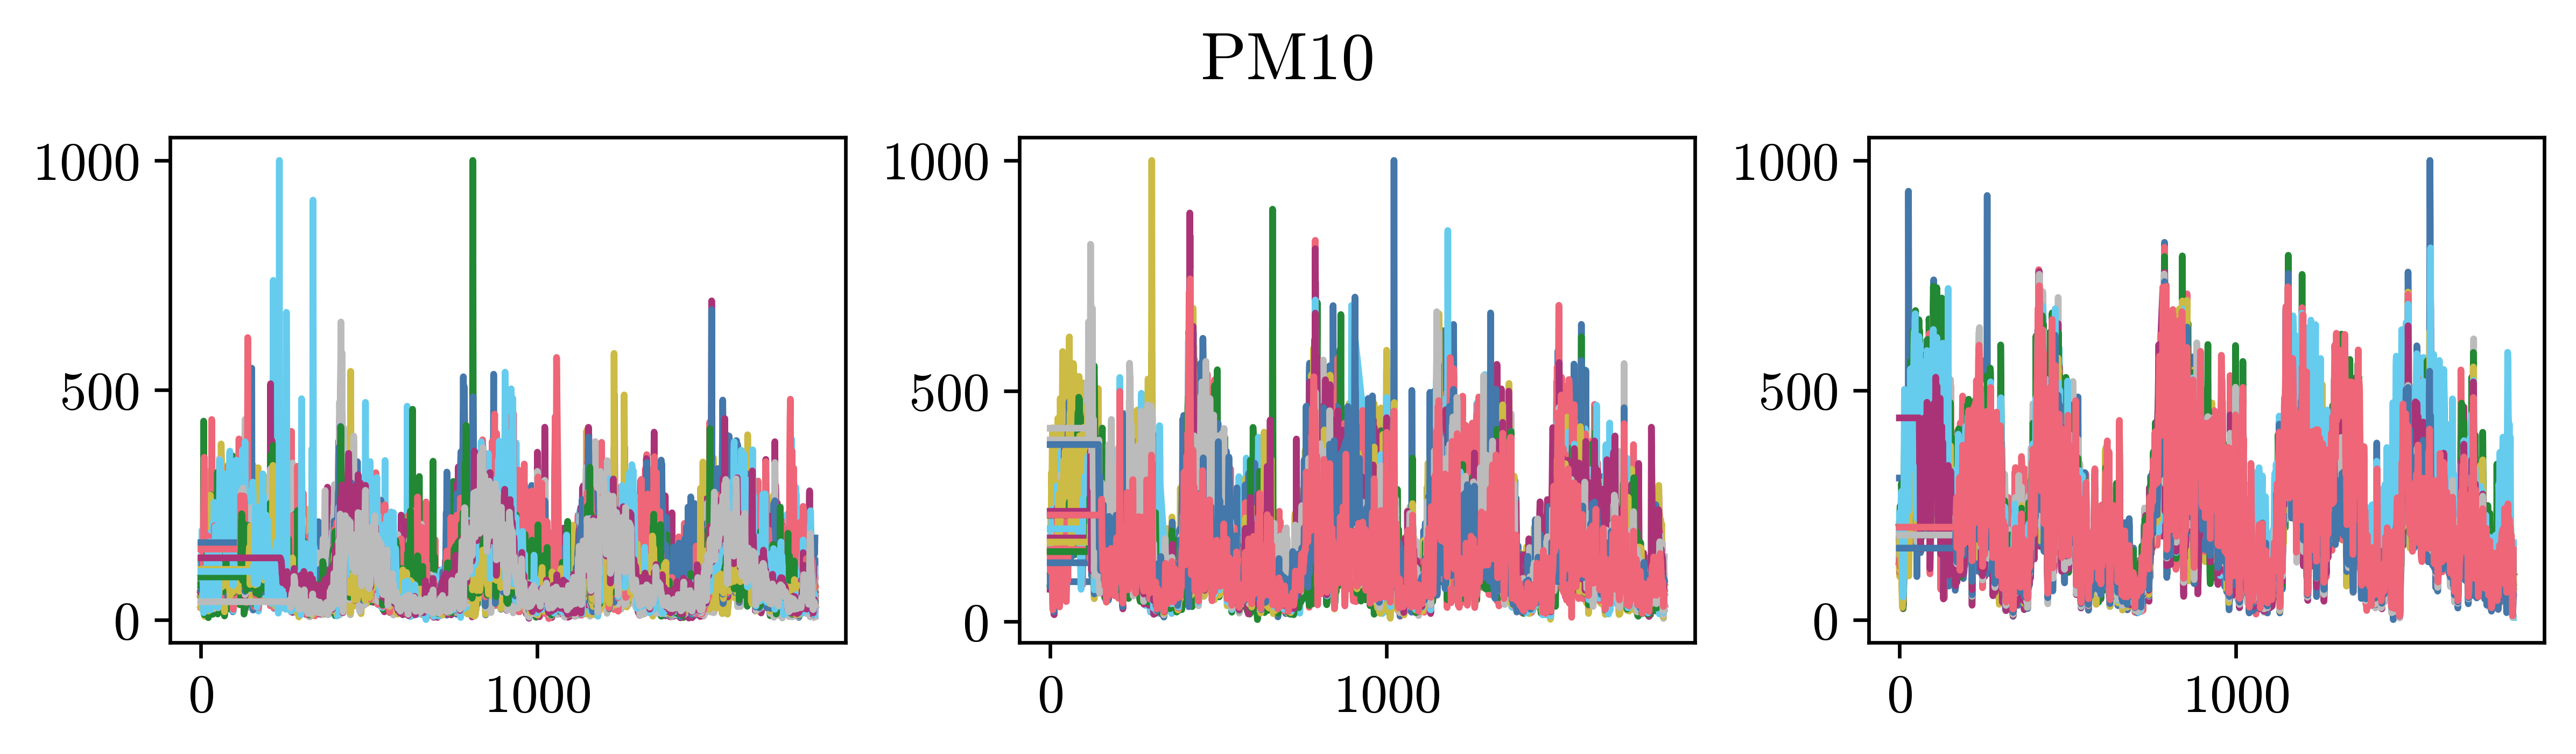

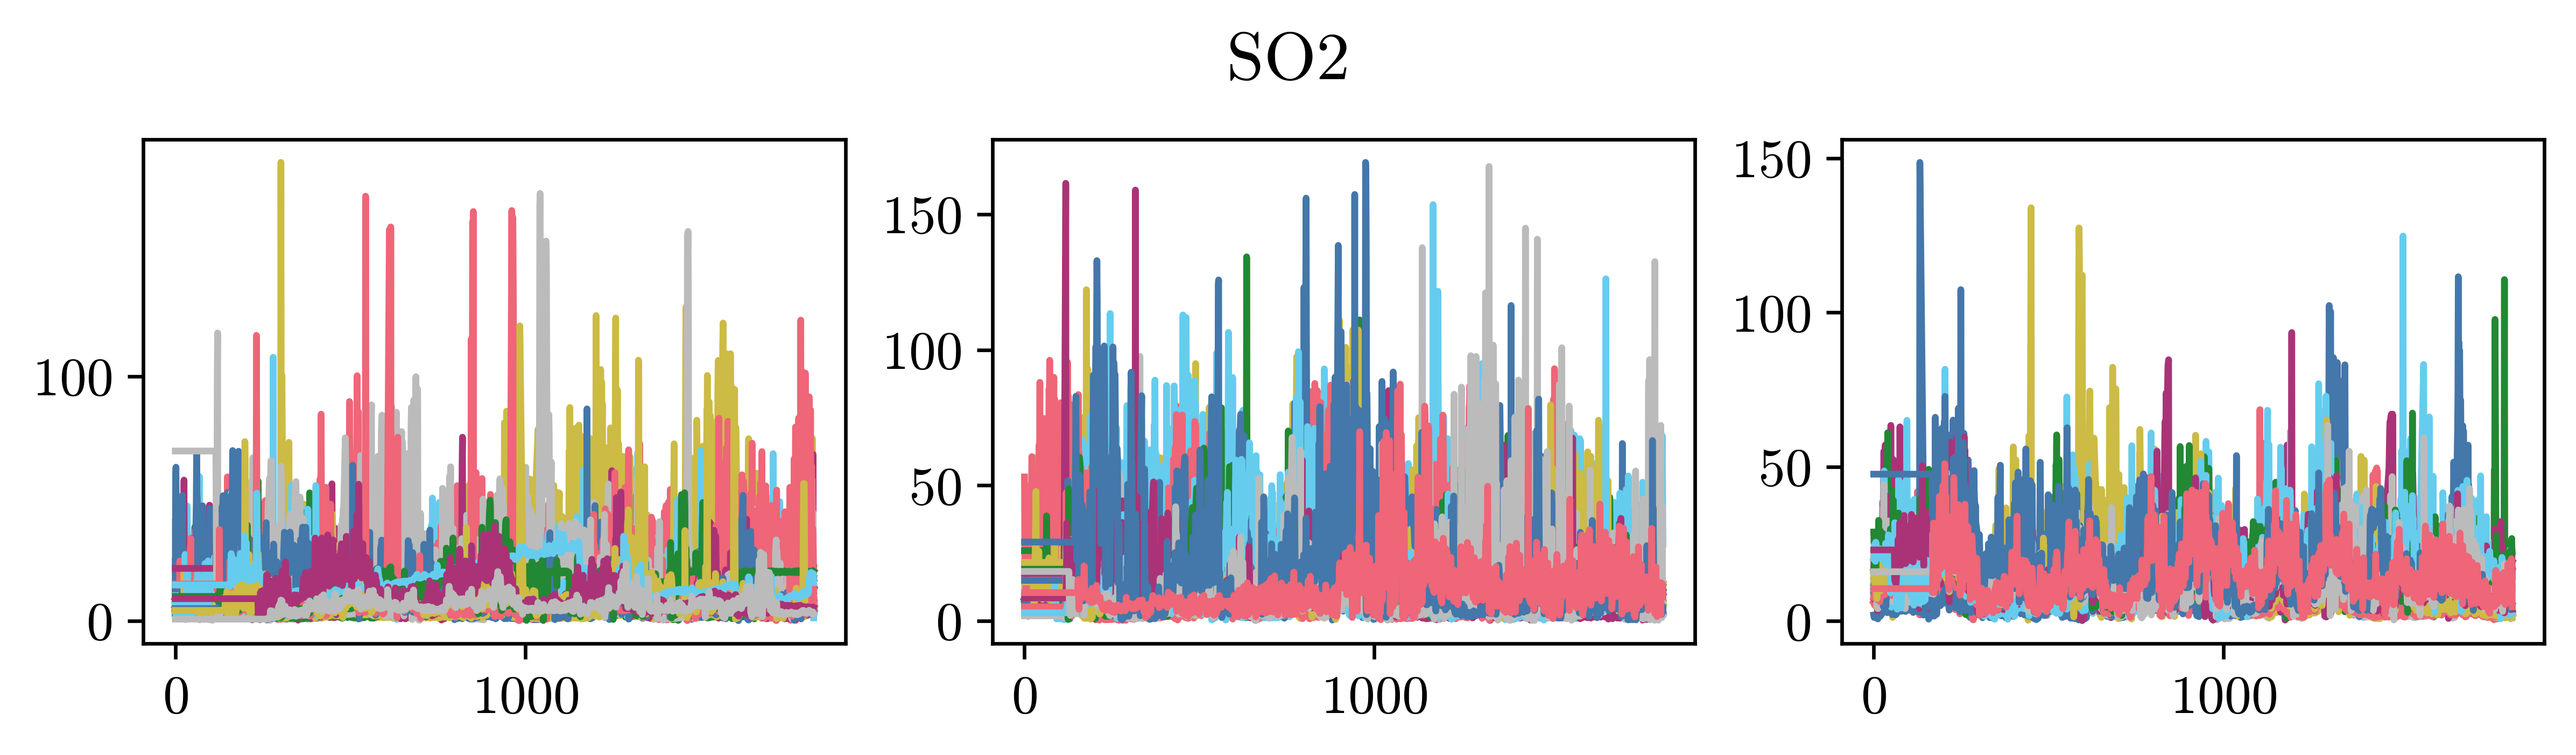

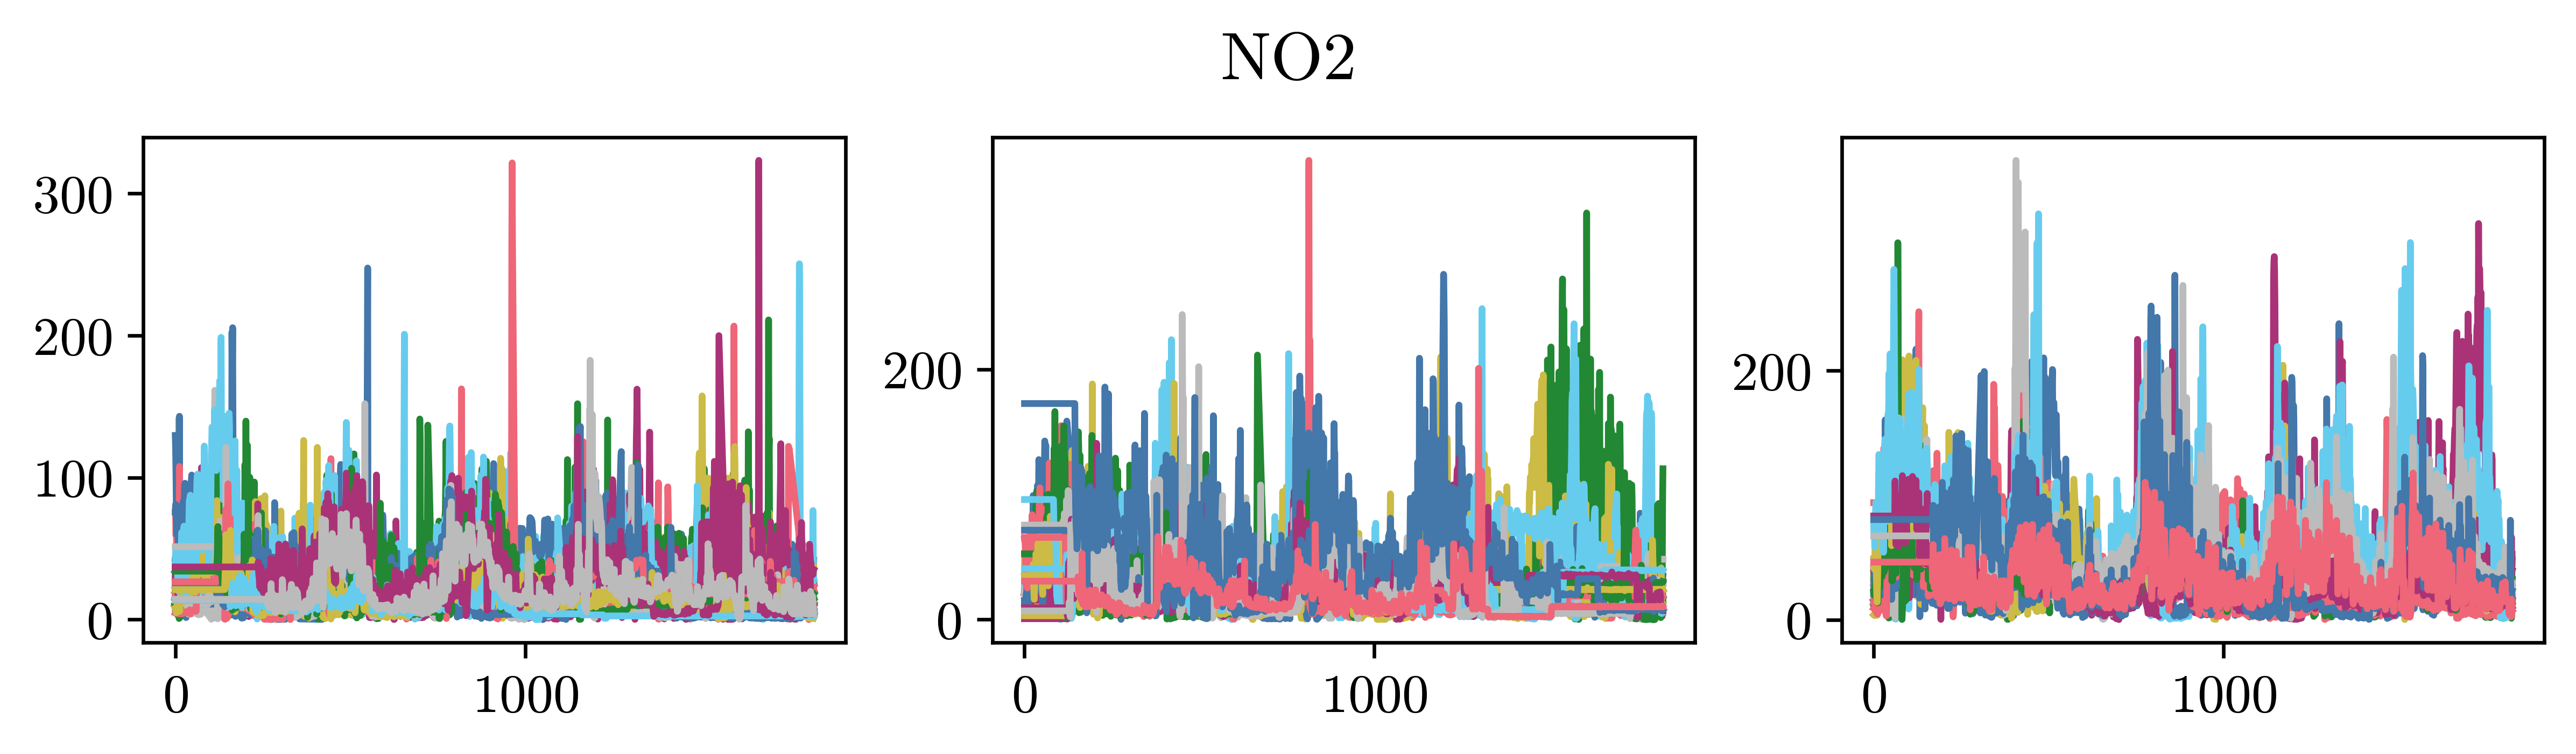

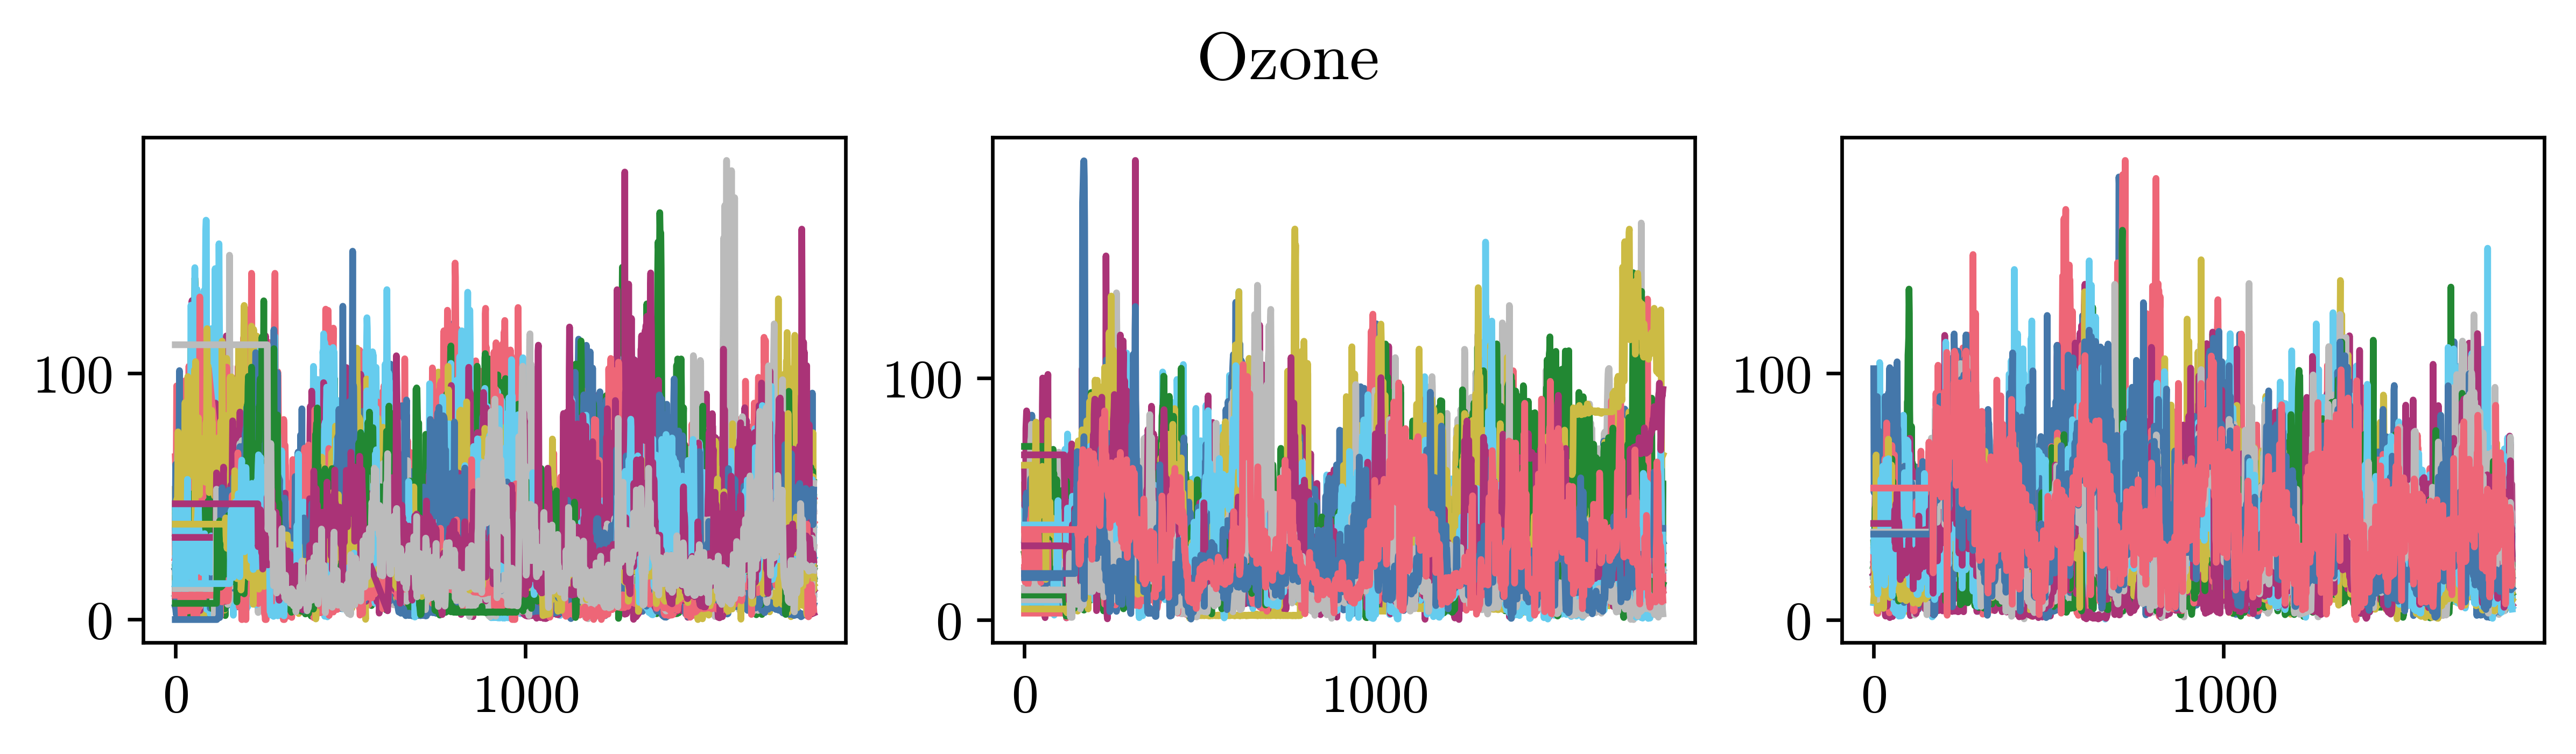

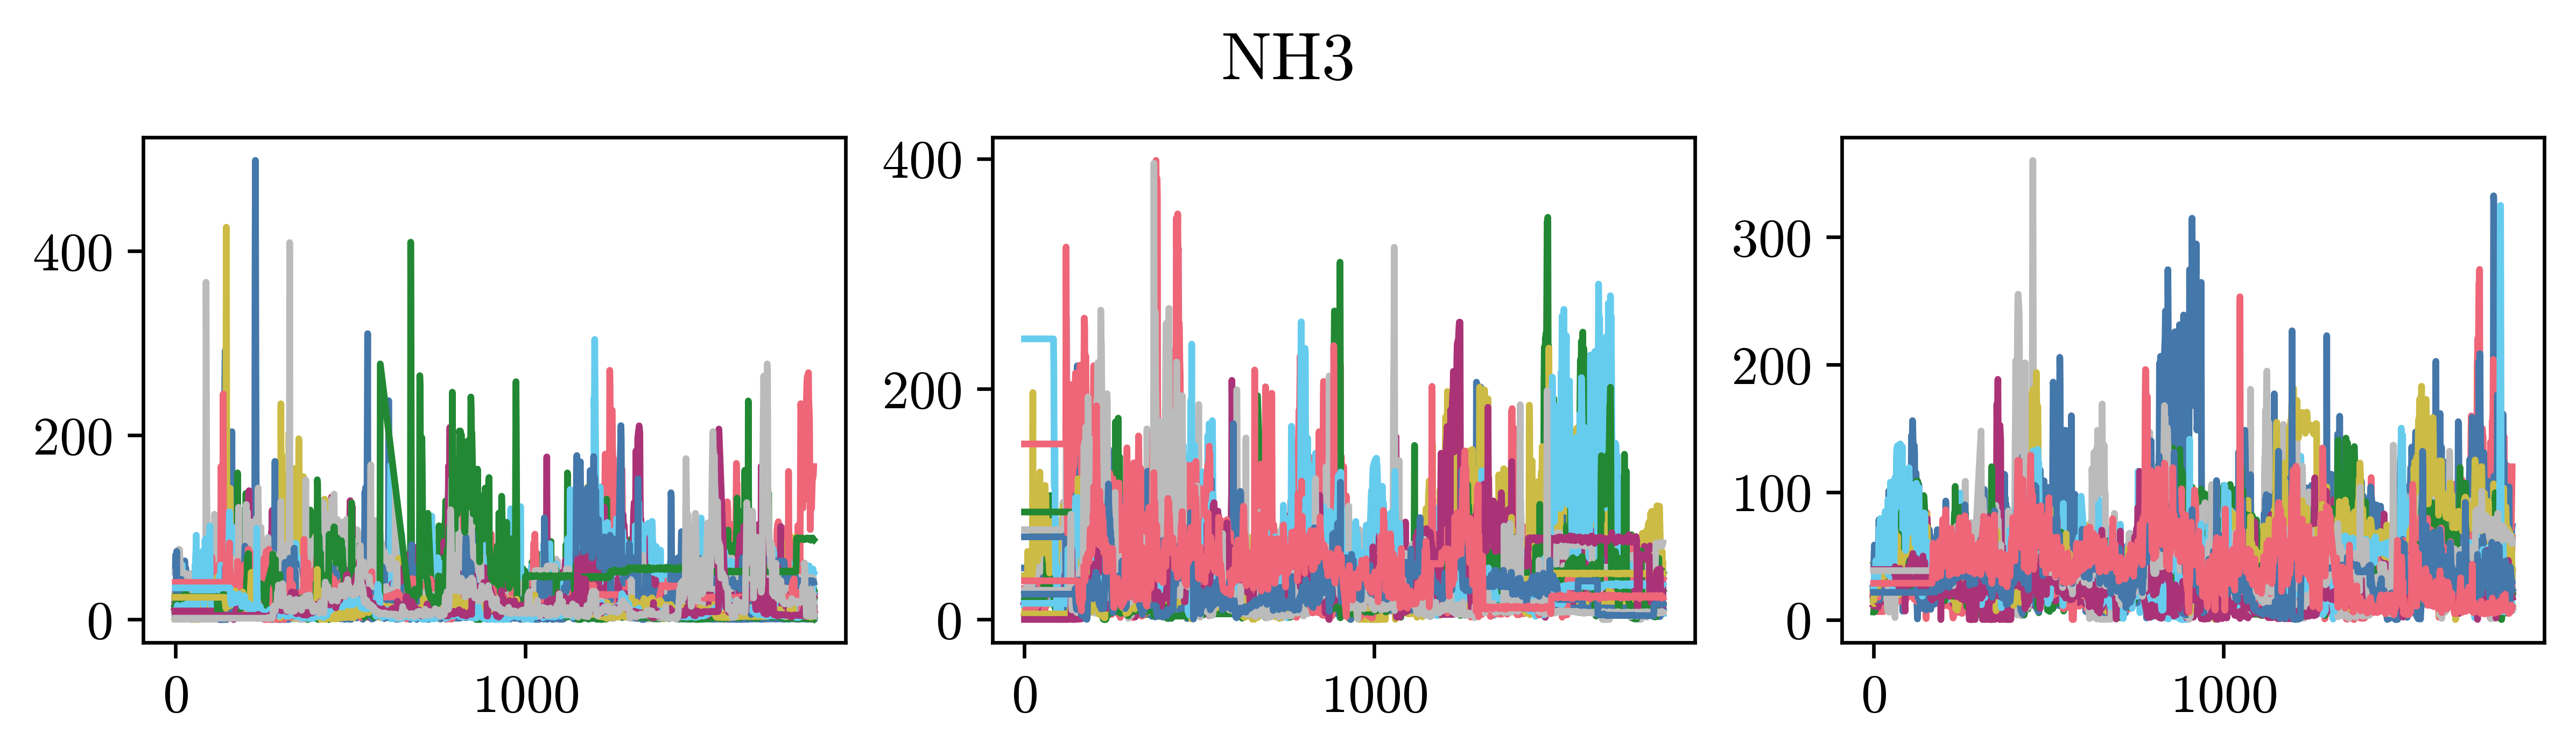

In [31]:
timeseries_plot(timeseries_data,5,cluster_labels)

In [14]:
df_stats=pd.DataFrame({'SiteId':[]})
for col in cols:
    df_stats[f'Mean_{col}']=[]

row=[]
for sid in tqdm(df_site_clustered.siteId.values):
    row=[]
    fname='D:\\BTP\\Data\\site_data_processed\\'+sid+'.csv'
    row.append(sid)
    df=pd.read_csv(fname)
    #df=df[(df['from date']>='01-01-2023')&(df['from date']<='31-12-2023')]
    df['from date']=pd.to_datetime(df['from date'])
    df=df[['from date','PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone', 'NH3']]
    df = df.resample('D', on='from date').mean().reset_index()
    for col in cols:
        df[col]=linear_int(df[col])
    row=row+list(df[cols].mean().values)
    df_stats.loc[len(df_stats)]=row
df_stats

  0%|          | 0/103 [00:00<?, ?it/s]

SiteId  Mean_PM2.5   Mean_PM10   Mean_SO2   Mean_NO2  Mean_Ozone  \
0     site_113   95.433874  175.349053  10.669922  52.830427   27.850557   
1     site_115  102.975149  198.888175  11.088070  29.334384   30.648074   
2     site_117  111.097934  171.298823  13.126146  42.885568   23.634430   
3     site_118  108.544851  218.043558  12.550612  38.287190   43.410222   
4     site_119   95.398702  220.842083  10.628002  35.168215   46.974848   
..         ...         ...         ...        ...        ...         ...   
98   site_5081   90.008675  198.262113  14.505123  61.111392   37.666335   
99   site_5082   86.668644  196.451492  20.195106  48.142277   40.211300   
100  site_5083  113.361503  237.073881  14.521635  34.516938   43.425691   
101  site_5101   50.784370  108.562724  10.883590  30.099830   30.991498   
102  site_5111   46.064749   87.336225   5.546317  22.781127   36.367537   

      Mean_NH3  
0    50.070519  
1    41.449844  
2    41.217810  
3    42.203688  
4    35.337076  
..         ...  
98   46.300473  
99   37.148088  
100  40.612290  
101  13.853772  
102  20.672974  

[103 rows x 7 columns]

In [57]:
df_site.merge(df_site_clustered,on='siteId').to_csv('India_clustered_final.csv',index=False)

## Analysing the clusters

In [ ]:
plt.boxplot(filtered_df['Overall_Score'])
plt.title("Overall Score for all Stations")
plt.show()

In [ ]:
len(filtered_df),len(filtered_df[filtered_df['Overall_Score']>0.48])

In [34]:
df_site_clustered.cluster.value_counts()

cluster
1    49
3    30
2    23
Name: count, dtype: int64

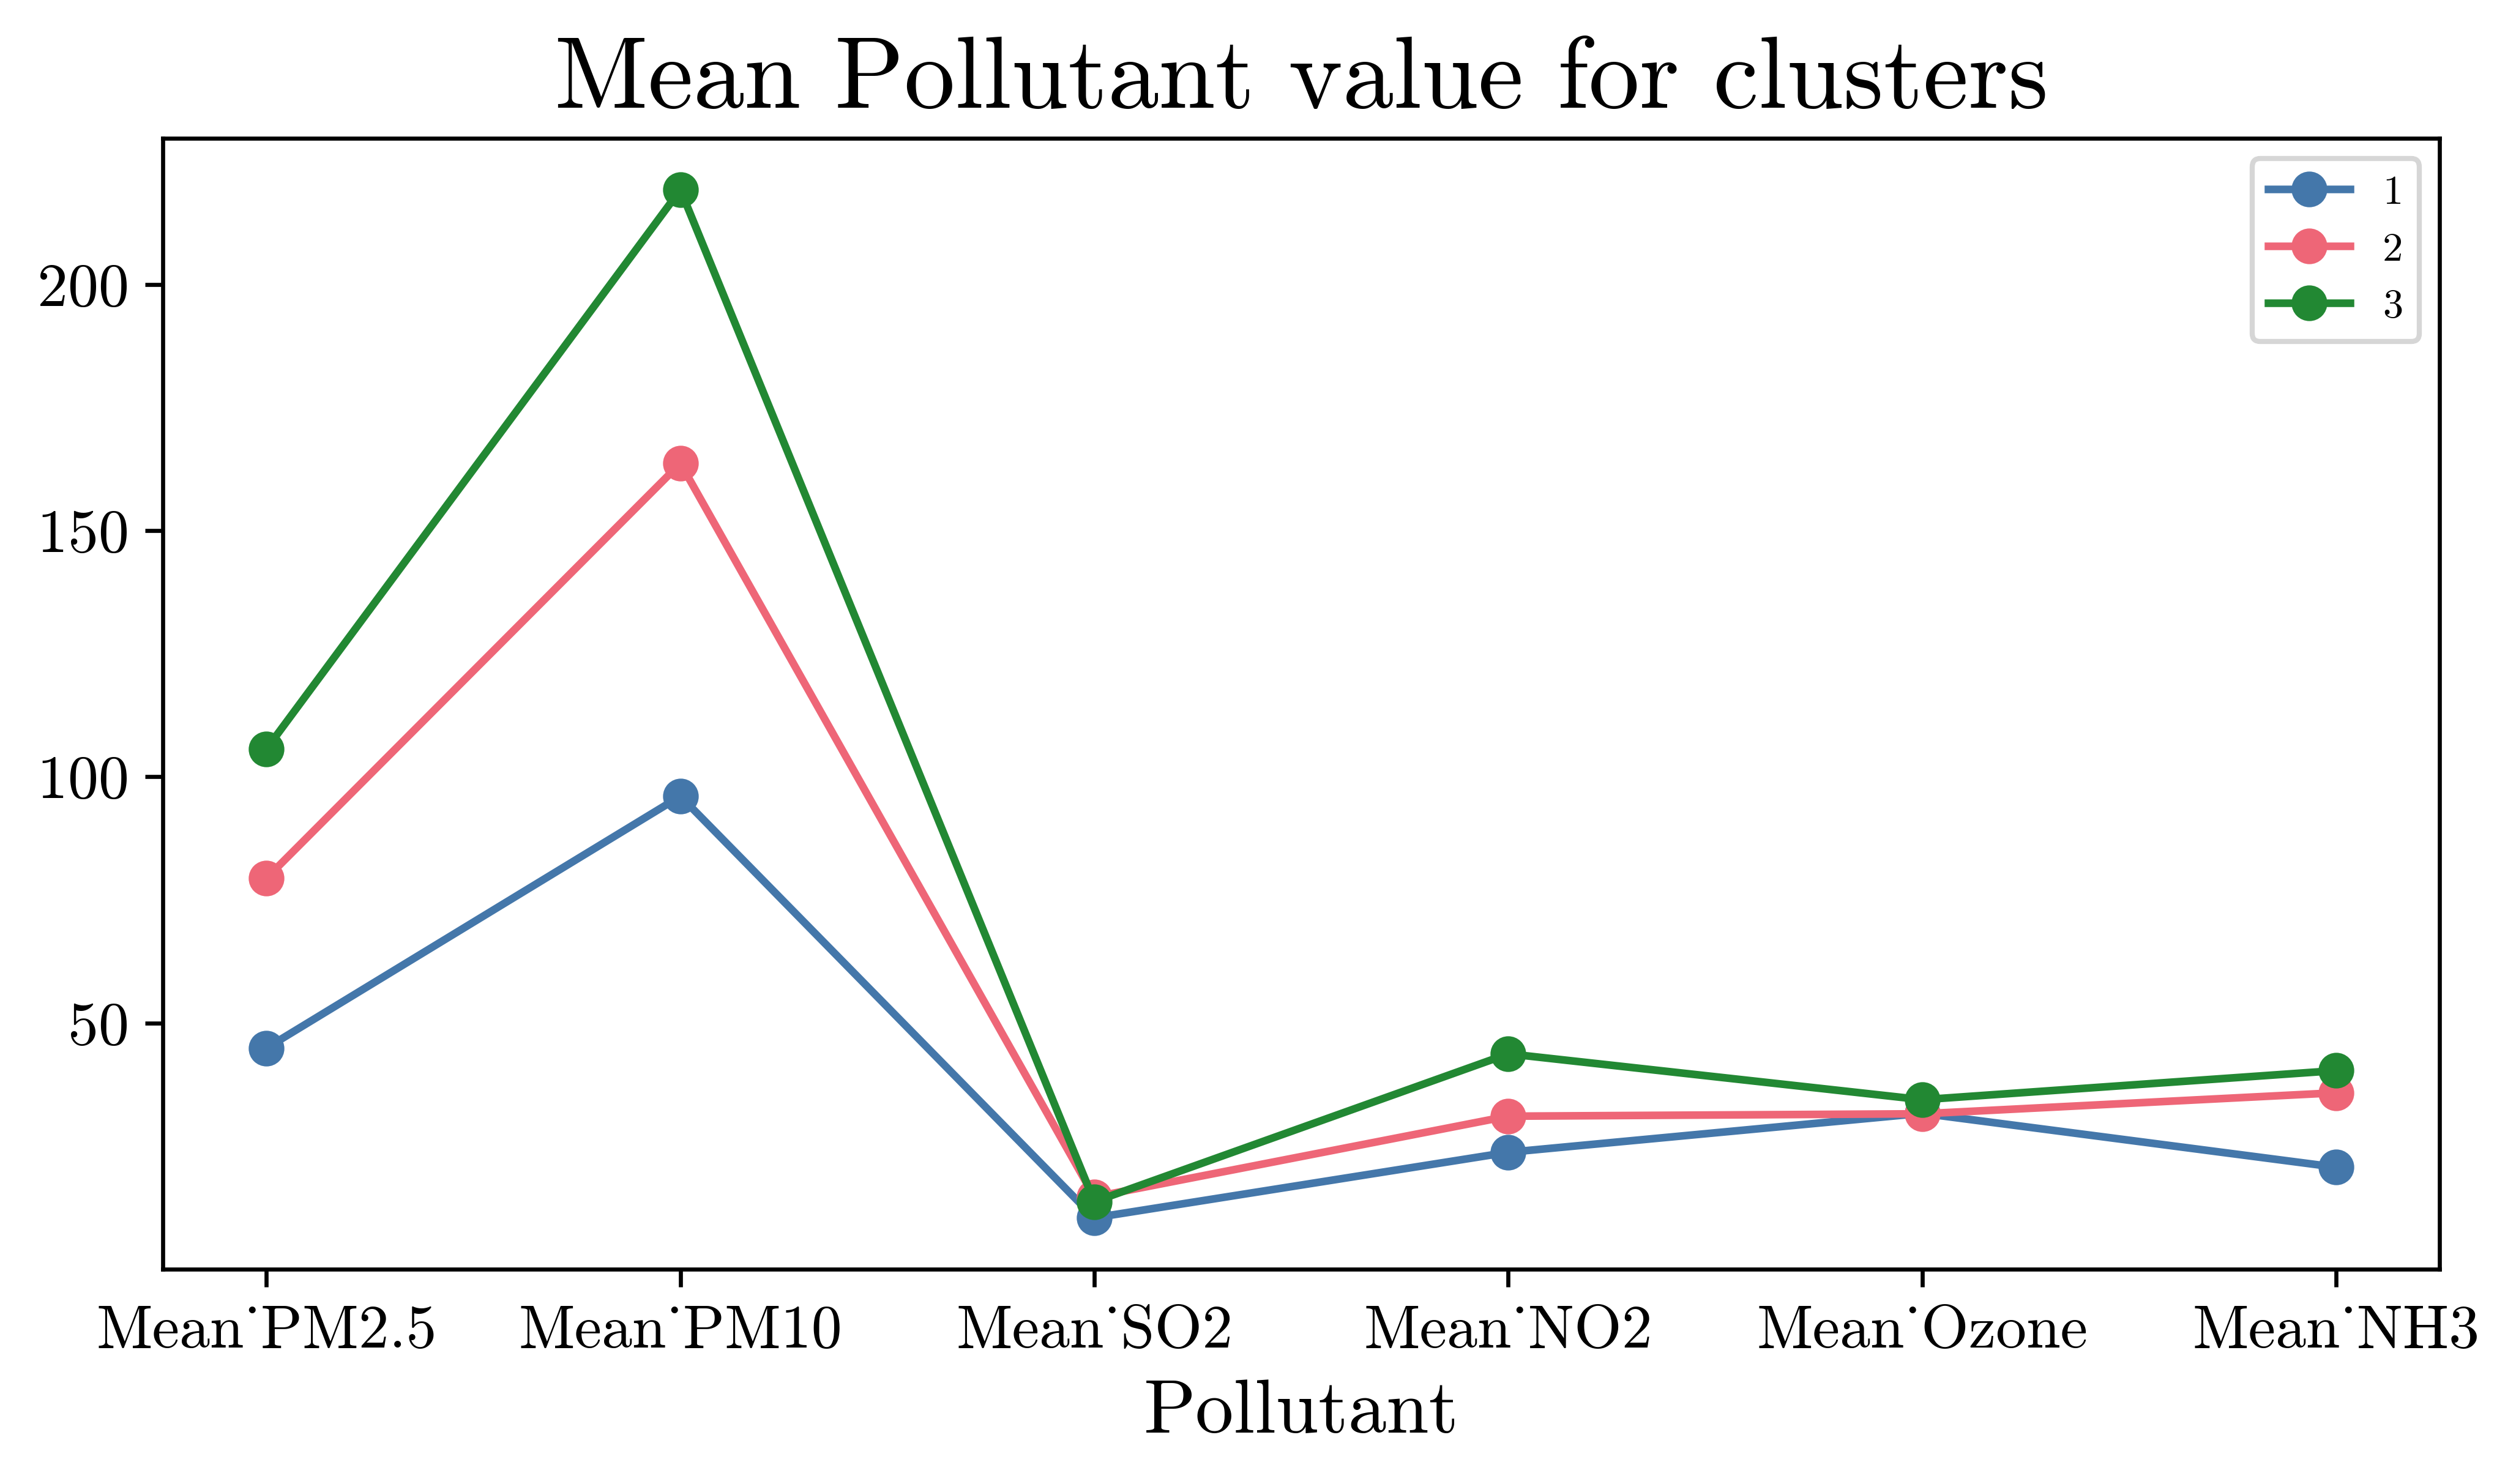

In [51]:
s=df_site_clustered[df_site_clustered.cluster==1].siteId.values
plt.plot(df_stats[df_stats['SiteId'].isin(s)].describe()[1:2].T,'-o')
s=df_site_clustered[df_site_clustered.cluster==2].siteId.values
plt.plot(df_stats[df_stats['SiteId'].isin(s)].describe()[1:2].T,'-o')
s=df_site_clustered[df_site_clustered.cluster==3].siteId.values
plt.plot(df_stats[df_stats['SiteId'].isin(s)].describe()[1:2].T,'-o')
plt.legend(['1','2','3'])
plt.title("Mean Pollutant value for clusters")
plt.xlabel("Pollutant")
plt.show()